# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier
In this project a Tensor flow pipeline was designed to classify the German Traffic Signs Dataset. Following steps were followed. 

   - Load the data set
   2. Explore, summarize and visualize the data set
   3. Design, train and test a model architecture
   4. Use the model to make predictions on new images
   5. Analyze the softmax probabilities of the new images
   6. Summarize the results with a written report



## Step 1: Load The Data
In this step pickeled data is extracted and stored in Lists for further usage 

In [1]:
# Load pickled data
import pickle
import numpy as np 

# File Path for training, validation and test pickled data
training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

# Read the files into respective files.
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Store the data into image and label list for each of the dataset
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#printout this shapes of the each of the dataset to understand the amount of input data.
print("X_train", np.shape(X_train))
print("X_valid", np.shape(X_valid))
print("X_test", np.shape(X_test))

print("Y_train", np.shape(y_train))
print("y_valid", np.shape(y_valid))
print("y_test", np.shape(y_test))


X_train (34799, 32, 32, 3)
X_valid (4410, 32, 32, 3)
X_test (12630, 32, 32, 3)
Y_train (34799,)
y_valid (4410,)
y_test (12630,)


## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

###  Basic Summary of the Data Set 

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = [len(X_train[1]),len(X_train[2])]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43


### Visualization of the dataset

Training Dataset is analyzed in this section. Using the mathplotlib histogram of the data is plotted.
From the histogram it is clear the data is quite unbalanced. Training the network with such varied data is a bit difficult.

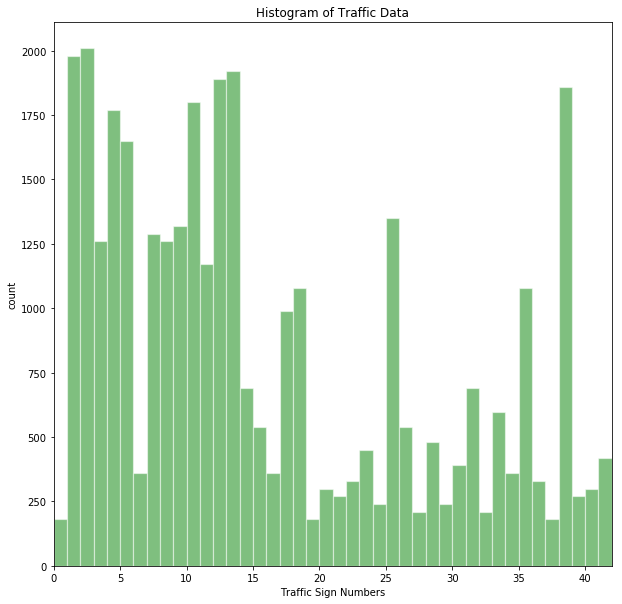

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import math
import matplotlib.pyplot as plt

## Histogram Plot
%matplotlib inline
plt.figure(figsize=(10,10))
bins = np.linspace(math.ceil(min(y_train)), 
                   math.floor(max(y_train)),
                   43) # fixed number of bins
plt.xlim([min(y_train), max(y_train)])
hist_num,hist_index,hist_patches = plt.hist(y_train,bins=bins, color= 'green',alpha=0.5,histtype='bar',edgecolor='white',linewidth=1.2)
plt.title('Histogram of Traffic Data')
plt.xlabel('Traffic Sign Numbers')
plt.ylabel('count')
plt.show()

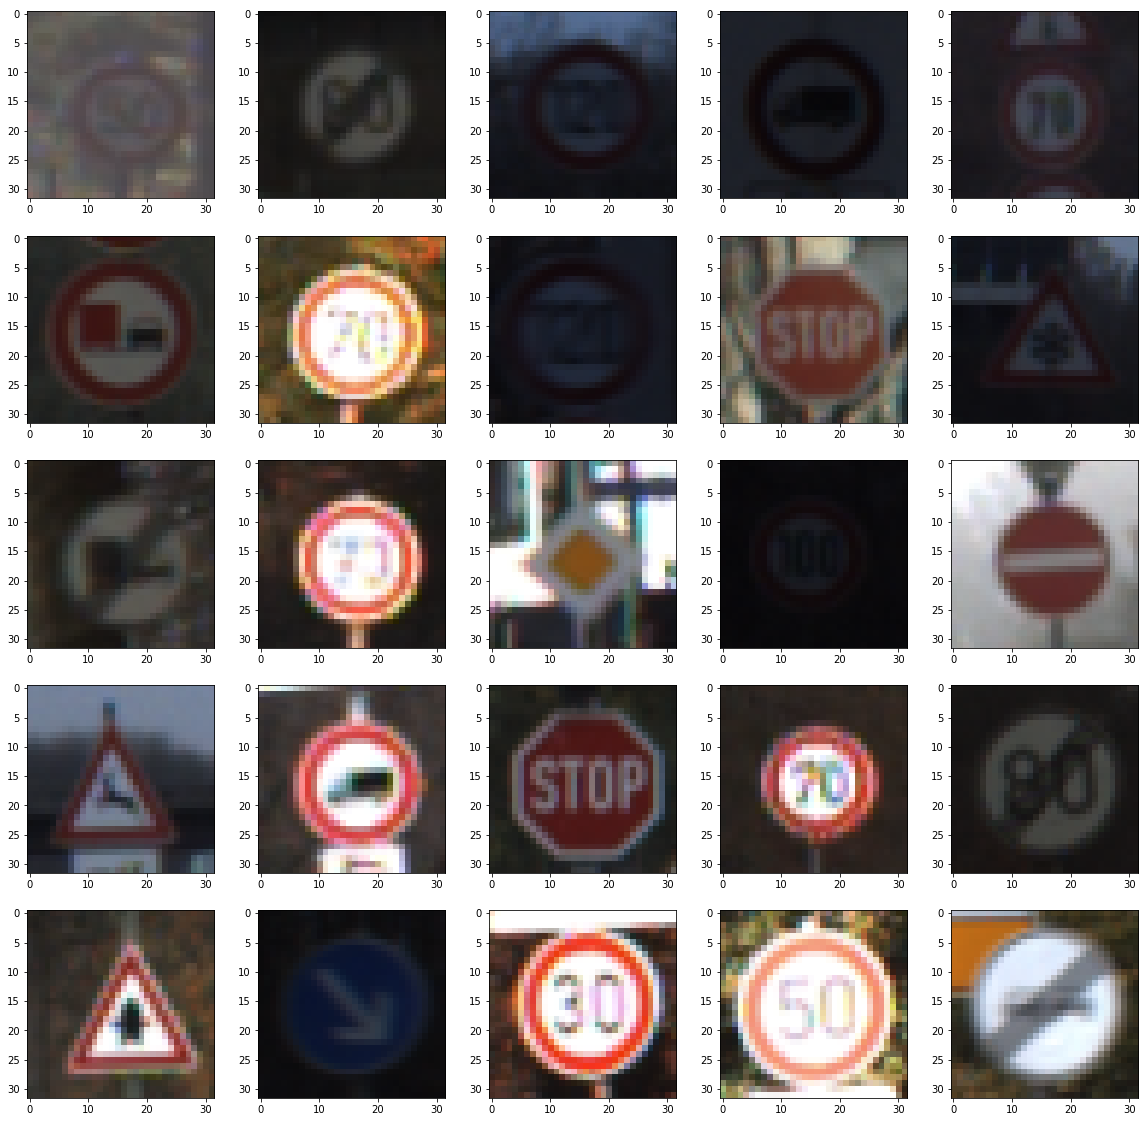

In [4]:
## From train images randomly images are picked and plotted
%matplotlib inline
fig = plt.figure(figsize=(20, 20))  # width, height in inches

for i in range(25):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    sub = fig.add_subplot(5, 5, i + 1)
    sub.imshow(image)

## Data Augmentation
From above steps it is known that training dataset is around 34799 images. Training the CNN using these images to achieve an accuracy of >93% was very difficult. By rotation and blurring the traffic signs that are very few are augmented such that a minimum of 1500 samples are present after preprocessing.

In [5]:
import numpy as np
import cv2
from scipy import ndimage
from sklearn.utils import shuffle  
from tqdm import tqdm

# Augment training data
'''
Inputs:
    images : list of input images  whose count is less than 1500
    labels : list of label,all the values in this list will be same
    size   : number of images to be added to train list to increase the count to 1500
    
Outputs:
    expanded_images: list of new images to be added to the existing train set
    expanded_labels: list of new labels to be added to the existing train set, these values are same as input 'labels'
'''
def expand_training_data(images, labels, size):
    
    expanded_images_data = np.empty([0,32,32,3])
    expanded_labels_data = np.empty([0])
    expanded_images = np.empty([0,32,32,3])
    expanded_labels = np.empty([0])

    j = 0 # counter
    while(j<size):
        for x, y in zip(images, labels):
            bg_value = np.median(x) # this is regarded as background's value        
            
            # rotate the image with random degree
            ang = 10
            ang_rot = np.random.uniform(ang)-ang/2
            rows,cols,ch = x.shape  
            Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)        
            new_img = cv2.warpAffine(x,Rot_M,(cols,rows))              
            
            # change the brightness
            new_img = cv2.cvtColor(new_img,cv2.COLOR_RGB2HSV)
            random_bright = .15+np.random.uniform()
            new_img[:,:,2] = new_img[:,:,2]*random_bright
            new_img = cv2.cvtColor(new_img,cv2.COLOR_HSV2RGB)
            
            # merge the images
            expanded_images=np.append(expanded_images,[new_img],axis=0)
            expanded_labels=np.append(expanded_labels,[y],axis=0)
            images,labels = shuffle(images,labels)
            j +=1       

    return expanded_images,expanded_labels

In [6]:
'''
Using the histogram output we can find the number of images per traffic sign. 
Find the traffic sign which has less than 1500 images , collect all
such traffic sign images and pass to expand_training_data function defined above.
'''
data_len_min = 1500 ## Minimum expected train image count per traffic sign 

total_images = np.empty([0,32,32,3])
total_labels = np.empty([0])

with tqdm(total=len(hist_index),unit='traffic sign') as pbar:
    for bar_len,index in zip(hist_num,hist_index):
        # check if the current traffic sign has less than 1500 samples
        if(bar_len<data_len_min):
            # Find images with the same traffic sign and store in an array
            img_processed = [X_train[i] for i in range(len(X_train)) if y_train[i] == np.uint8(index)]
            if len(img_processed)>0:
                # Find labels with the same traffic sign and store in an array
                y_processed = [y_train[i] for i in range(len(X_train)) if y_train[i] == np.uint8(index)]
            
            img_processed_aft,y_processed_aft =  expand_training_data(img_processed,y_processed,(data_len_min-len(y_processed))) 
            
            # Store the new images in a temporary list
            total_images = np.append(total_images,img_processed_aft,axis=0)
            total_labels = np.append(total_labels,y_processed_aft,axis=0)
            
        pbar.update(1)

# Added the new images and labels to the existing train lists
X_train=np.append(X_train,total_images,axis=0)
y_train=np.append(y_train,total_labels,axis=0)     

# Clear off the unused lists to save the memory
total_images = None
total_labels = None
img_processed = None
img_processed_aft = None
y_processed_aft = None
y_processed = None

 98%|█████████▊| 42/43 [06:11<00:10, 10.97s/traffic sign]


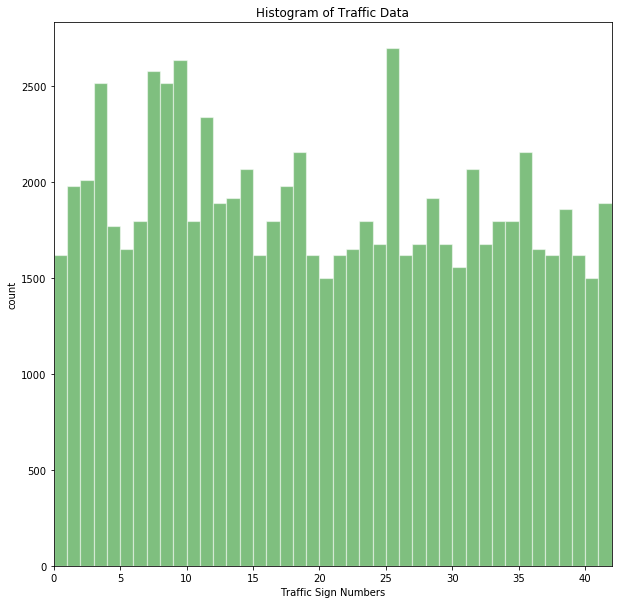

In [7]:
'''
Plot the histogram of X_train after data augmentation and check if 
the minimum count per traffic sign is atleast 1500
'''
%matplotlib inline
plt.figure(figsize=(10,10))
bins = np.linspace(math.ceil(min(y_train)), 
                   math.floor(max(y_train)),
                   43) # fixed number of bins
plt.xlim([min(y_train), max(y_train)])
hist_num,hist_index,hist_patches = plt.hist(y_train,bins=bins, color= 'green',alpha=0.5,histtype='bar',edgecolor='white',linewidth=1.2)
plt.title('Histogram of Traffic Data')
plt.xlabel('Traffic Sign Numbers')
plt.ylabel('count')
plt.show()

In [8]:
'''
Update n_train and n_classes variables after data agumentation
'''
n_train = len(X_train)
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of classes =", n_classes)

Number of training examples = 79347
Number of classes = 43


## Step 3: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test the model using augmented train data.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [9]:
'''
Function : RGB2Gray_Image

input : RGB images 

output : Gray Scale images

method: R,G,B values for each pixel are multiplied by 0.299,0.587,0.114 
        respectively and added to a single value. Resultant value is the output.
        To avoid using a lot of memory at a time not more than 10000 images are processed
        
'''
def RGB2Gray_Image(rgb_image):  
    total_inp_size = len(rgb_image)
    gray_img = np.empty([0,32,32,1])
    for offset in tqdm(range(0, total_inp_size, 10000),unit='traffic sign'):
        tmp_image = np.array(rgb_image[offset:offset+10000])
        gray_img = np.append(gray_img,\
                             np.uint8(np.reshape(tmp_image[:,:,:,0]*0.299+\
                                                 tmp_image[:,:,:,1]*0.587+tmp_image[:,:,:,2]*0.114,\
                                                 (len(tmp_image),32,32,1))),axis=0)
    return(gray_img)

'''
Function : normalize_grayscale

input : The image data to be normalized

output : Normalized image data

method:  Normalize the image data with (pixel - 128)/ 128
        
'''
def normalize_grayscale(image_data):
    norm_image = ((image_data-128)/128)   
    return(norm_image)

### Train Images Preprocessing

100%|██████████| 8/8 [00:37<00:00,  4.38s/traffic sign]


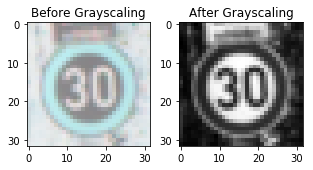

In [10]:
%matplotlib inline
index = random.randint(0, len(X_train))
fig = plt.figure(figsize=(5, 5))  # width, height in inches
sub = fig.add_subplot(2, 2, 1)
before_img = X_train[index].squeeze()
sub.set_title("Before Grayscaling")
sub.imshow(before_img,cmap="gray")

gray_images = RGB2Gray_Image(X_train)
X_train = normalize_grayscale(gray_images)
X_gray_train = None

sub = fig.add_subplot(2, 2, 2)
after_img = X_train[index].squeeze()
sub.set_title("After Grayscaling")
sub.imshow(after_img, cmap="gray")


### Validation Images Preprocessing

In [11]:
gray_images = RGB2Gray_Image(X_valid)
X_valid = normalize_grayscale(gray_images)

100%|██████████| 1/1 [00:43<00:00, 43.67s/traffic sign]


### Model Architecture

### Architecture
Following architecture was used for this project 

**Layer 1: Convolutional.** The output shape should be 28x28x16.

**Activation.** Selu activation function.

**Pooling.** The output shape should be 14x14x16.

**Layer 2: Convolutional.** The output shape should be 10x10x32.

**Activation.** Selu activation function.

**Pooling.** The output shape should be 5x5x16.

**Layer 3: Convolutional.** The output shape should be 4x4x64.

**Activation.** Selu activation function.

**Pooling.** The output shape should be 2x2x64.


**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 256 outputs.

**Activation.** Selu activation function.

**Layer 4: Fully Connected.** This should have 128 outputs.

**Activation.** Selu activation function.

**Layer 5: Fully Connected.** This should have 84 outputs.

**Activation.** Selu activation function.

**Layer 6 Fully Connected (Logits).** This should have 43 outputs.

### Output
Return the result of the 3rd fully connected layer.

Selu function is used as activation function for this project. Because of performance advantages like fast raise in accuracy and very limited oscillations. I choose this function after trying many architectures with Relu. Selu is based on below formula. For this project i used an aplha '1.6732632423543772848170429916717' and scale  of '1.0507009873554804934193349852946' which i found online.
![alt text](selu.png "Title")

In [12]:
import tensorflow as tf
'''
Input: x
Output: selu(x)
'''
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

In [13]:
EPOCHS = 100 # Number of training cycles
BATCH_SIZE = 256 #  Number of training data images used at a time.

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return selu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Store layers weight & bias
    weights = {
        'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32),mean = mu, stddev = sigma)),
        'wc3': tf.Variable(tf.truncated_normal(shape=(2, 2, 32, 64),mean = mu, stddev = sigma)),
        'wd1': tf.Variable(tf.truncated_normal(shape=(2*2*64, 256),mean = mu, stddev = sigma)),
        'wd2': tf.Variable(tf.truncated_normal(shape=(256, 128),mean = mu, stddev = sigma)),
        'wd3': tf.Variable(tf.truncated_normal(shape=(128, 84),mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal(shape=(84, 43),mean = mu, stddev = sigma))}

    biases = {
        'bc1': tf.Variable(tf.zeros([16])),
        'bc2': tf.Variable(tf.zeros([32])),
        'bc3': tf.Variable(tf.zeros([64])),
        'bd1': tf.Variable(tf.zeros([256])),
        'bd2': tf.Variable(tf.zeros([128])),
        'bd3': tf.Variable(tf.zeros([84])),
        'out': tf.Variable(tf.zeros([43]))}
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    # Activation.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Pooling. Input = 28x28x6. Output = 14x14x16.
    conv1 = maxpool2d(conv1, k=2)
    
    # Layer 2: Convolutional. Output = 10x10x32.
    # Activation.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = maxpool2d(conv2, k=2)
    
    # Layer 3: Convolutional. Output = 4x4x64.
    # Activation.
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Pooling. Input = 4x4x64. Output = 2x2x64.
    conv3 = maxpool2d(conv3, k=2)
    
    # Flatten the 3D array 
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Layer 4: Fully Connected. Input = 256. Output = 128.
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Activation.
    fc1 = selu(fc1)
    
    # Layer 5: Fully Connected. Input = 128. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    # Activation.
    fc2 = selu(fc2)
    
    # Layer 6: Fully Connected. Input = 84. Output = 43.
    fc3 = tf.add(tf.matmul(fc2, weights['wd3']), biases['bd3'])
    # Activation.
    fc3 = selu(fc3)
    fc2 = tf.nn.dropout(fc2,keep_prob=0.9)
    
    # Layer 7: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
        
    return logits

## Train, Validate and Test the Model

### Features and Labels
`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline
Create a training pipeline that uses the model to classify Traffic Signs data.

In [15]:
from tensorflow.python.framework import ops
rate = 0.002

# Pass the data to architecture for training
logits = LeNet(x)
# Compare the output of the architecture with the actual values
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# Optimize the error using adamoptimzer
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation
Function to evaluate how well the loss and accuracy of the model are trained for a given dataset.

In [16]:
# Check the accuracy of the model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set. Exit the loop if the accuracy is more than 95.9

Save the model after training.

Plot the accuracy trend over the epoches

Training...

EPOCH 1 :Validation Accuracy = 0.899

Model saved
EPOCH 2 :Validation Accuracy = 0.920

Model saved
EPOCH 3 :Validation Accuracy = 0.922

Model saved
EPOCH 4 :Validation Accuracy = 0.936

Model saved
EPOCH 5 :Validation Accuracy = 0.935

EPOCH 6 :Validation Accuracy = 0.934

EPOCH 7 :Validation Accuracy = 0.934

EPOCH 8 :Validation Accuracy = 0.941

Model saved
EPOCH 9 :Validation Accuracy = 0.939

EPOCH 10 :Validation Accuracy = 0.936

EPOCH 11 :Validation Accuracy = 0.946

Model saved
EPOCH 12 :Validation Accuracy = 0.934

EPOCH 13 :Validation Accuracy = 0.928

EPOCH 14 :Validation Accuracy = 0.939

EPOCH 15 :Validation Accuracy = 0.942

EPOCH 16 :Validation Accuracy = 0.937

EPOCH 17 :Validation Accuracy = 0.946

Model saved
EPOCH 18 :Validation Accuracy = 0.936

EPOCH 19 :Validation Accuracy = 0.937

EPOCH 20 :Validation Accuracy = 0.944

EPOCH 21 :Validation Accuracy = 0.954

Model saved
EPOCH 22 :Validation Accuracy = 0.944

EPOCH 23 :Validation Accuracy = 0.942

EPO

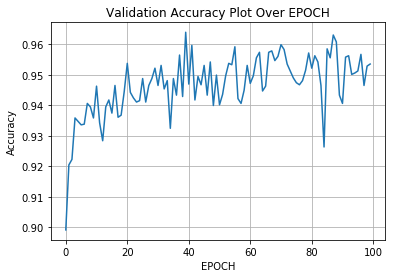

In [17]:
from sklearn.utils import shuffle  
from tensorflow.python.client import timeline
import datetime

# Note start time
t_start = datetime.datetime.now()
validation_accuracy = np.empty([0])
epoch_count =  np.empty([0])
max_model_accuracy = 0.0
saved_accuracy =0.0
saved_epoch =0

%matplotlib inline

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # Shuffle the train data 
        X_train, y_train = shuffle(X_train, y_train)
        
        
        # Feed data in batches 
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        # Calculate the accuracy of the model w.r.t validation data  
        validation_accuracy = np.append(validation_accuracy,evaluate(X_valid, y_valid))
        print("EPOCH {} :Validation Accuracy = {:.3f}".format(i+1,validation_accuracy[-1]))
        print()  
        epoch_count = np.append(epoch_count,i)
        
        if(validation_accuracy[-1]>max_model_accuracy):
            saver.save(sess, './lenet',global_step=i)
            
            saved_accuracy = validation_accuracy[-1]
            saved_epoch = i
            
            print("Model saved")         
            
            # Max accuracy till now
            max_model_accuracy = max(validation_accuracy)
   
print("EPOCH: {} with Validation Accuracy={:.3f} is saved".format(saved_epoch,saved_accuracy))    
    
t_stop = datetime.datetime.now()
te = t_stop - t_start
# print the time it took to  train the model
print("Total Execution Time:",te) 
# Plot the accuracy trend
plt.plot(epoch_count, validation_accuracy)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Plot Over EPOCH')
plt.grid(True)
plt.show()    

In [18]:
print("Final Accuracy of the model = {:.3f}%".format(max_model_accuracy*100))

Final Accuracy of the model = 96.395%


## Step 4: Test  Model on Test Images 
In this section Model tuned in the above step is test using Test Images shared along with the project.

### Preprocess Images and Model Testing
Test images are read from test.p file shared along with the project and the data is loaded in X_test and y_test lists in the very first steps. In this part of the project following steps are performed.
1. Preprocess the images in X_test (i.e RGB to GrayScale and normalization)
2. Preprocessed images are fed to the tensor 'evaluate' and the resultant accuracy is printed out

In [19]:
#### PreProcess the Test Images in X_Test ###
X_test_processed = RGB2Gray_Image(X_test)
X_test_processed = normalize_grayscale(X_test_processed)

### Feed the processed images and labels to evaluate tensor , print the accuracy of the model###
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Restore the model tuned parameters #
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_processed, y_test)
    print()
    print("Prediction Accuracy = {:.3f}%".format(test_accuracy*100))

100%|██████████| 2/2 [00:03<00:00,  2.57s/traffic sign]


INFO:tensorflow:Restoring parameters from ./lenet-39

Prediction Accuracy = 93.587%


## Step 5: Test Model on New Images

In this section images downloaded from the web are fed to the trained model and accuracy of predictions are printed out.
Following steps are followed to achieve goal.

1. Load the images from the folder and plot
2. Pre Process the web images (i.e RGB to GrayScale and Normalization)
3. Feed the Pre-Processed images to the tuned image and Predict
4. Plot the predictions.

### Load the web images

Total Number of images  found: 10


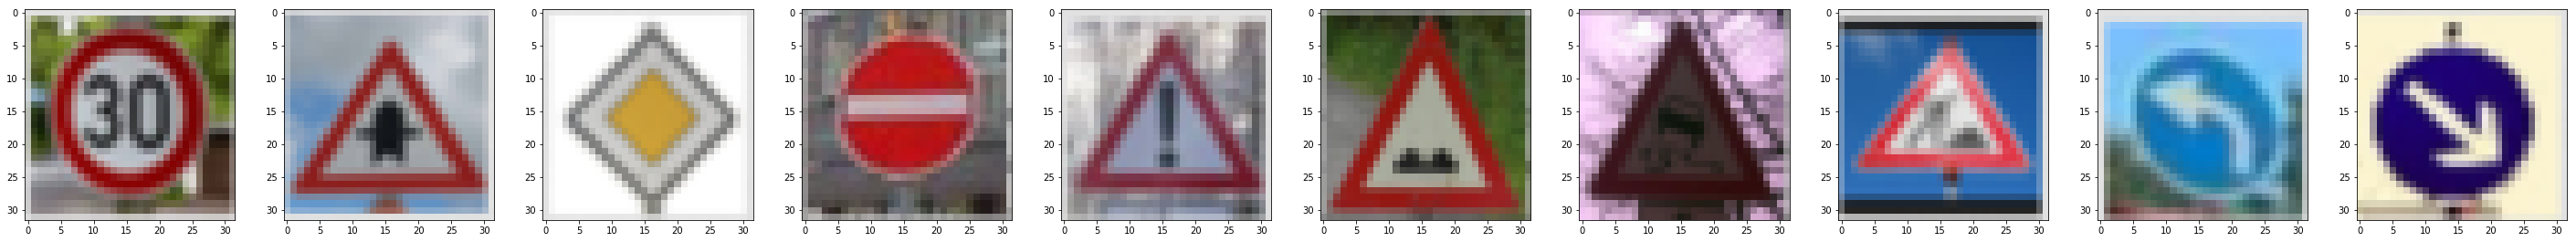

In [20]:
import os
import re
from scipy import misc

web_images = []
#Search the directory in the given and load all the images
for root, dirnames, filenames in os.walk("web_image"):
    for filename in sorted(filenames):
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            image_resized = misc.imresize(image, (32, 32))
            web_images.append(image_resized)
            
%matplotlib inline
fig = plt.figure(figsize=(50, 50))  # width, height in inches
i =0
for tmp in web_images:
    image = tmp.squeeze()
    sub = fig.add_subplot(len(web_images), len(web_images), i + 1)
    sub.imshow(image, cmap="gray", interpolation='nearest')
    i +=1
print("Total Number of images  found:",len(web_images))

### Pre-Process the web images

**Input:** Images read in the above step are used as an input to this step.

**Output:** Normalized GrayScale Images 

**Method:** Following steps were followed to achieve this goal 

    1. Feed the web images read from the above step to RGB2Gray_Image
    2. Output of RGB2Gray_Image function is fed to normalize_grayscale

In [21]:
## Convert the RGB Images to GrayScale  and Normalize
gray_images = RGB2Gray_Image(web_images)
gray_images = normalize_grayscale(gray_images)

100%|██████████| 1/1 [00:00<00:00, 1418.43traffic sign/s]


## Predict the Sign Type for Each Web Image

In this step using the pre processed web images predications are made to understand the behavior of the model on the new images.

**Input:** Images read and pre processed in the above step are used as an input to this step.

**Output:** Following are the list of ouputs from this step
        1. test_accuracy : Accuracy of the prediction , sum of correcteness of each of the prediction made
        2. predicted_images : Prediction on each of the images 

**Method:** Following steps  were followed to achieve this goal
        1. Restore tunned model parameters.
        2. Using Tensor Flow argmax find the prediction for each of the input image and store the result in predicted_images
        3. Using evaluate function defined above predict overall accuracy of the model for the web images and store this result in test_accuracy
        4. Print out the individual image  prediction using pandas

In [22]:
from sklearn.utils import shuffle  
from pandas import DataFrame

## Labels of the web images feed ##
actual_lables = [1,11,12,17,18,22,23,25,34,38]
## test_predi_output is used for getting individual image prediction
test_predi_output = tf.argmax(logits, 1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Restore the model tuned parameters #
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    predicted_images = sess.run(test_predi_output, feed_dict={x: gray_images, y: actual_lables})
    ## over all model accuracy
    test_accuracy = evaluate(gray_images,actual_lables)
    print()
    print("Prediction Accuracy = {:.3f}".format(test_accuracy))

print()
print("Test Images:",actual_lables)
print()


with open('signnames.csv') as csvfile:
    next(csvfile) # ignore header
    a = [ row.strip().split(',') for row in csvfile]
    signnames_dict = dict((data[0],data[1:]) for data in a)
    
#Show the results in Table using Pandas 
print("=========================Predicted Labels===========================")
res = "Match"
pred_data = np.empty([0,3])
img_count = np.empty([0])

tab_name = ["Predicted_Image_No","Predicted_Image_Name","Match/Miss_Match"]

for idx in range(len(predicted_images)):
    if actual_lables[idx] == predicted_images[idx]:
        res = "Match"
    else:
        res = "Miss Match"
    pred_data = np.append(pred_data,\
                          [[predicted_images[idx],str(signnames_dict[str(predicted_images[idx])]),res]],\
                          axis=0)
    img_count = np.append(img_count,["Test Image"+str(idx)],axis=0)

DataFrame(pred_data,img_count,tab_name)

INFO:tensorflow:Restoring parameters from ./lenet-39

Prediction Accuracy = 1.000

Test Images: [1, 11, 12, 17, 18, 22, 23, 25, 34, 38]

=========================Predicted Labels===========================


,Predicted_Image_No,Predicted_Image_Name,Match/Miss_Match
Test Image0,1,['Speed limit (30km/h)'],Match
Test Image1,11,['Right-of-way at the next intersection'],Match
Test Image2,12,['Priority road'],Match
Test Image3,17,['No entry'],Match
Test Image4,18,['General caution'],Match
Test Image5,22,['Bumpy road'],Match
Test Image6,23,['Slippery road'],Match
Test Image7,25,['Road work'],Match
Test Image8,34,['Turn left ahead'],Match
Test Image9,38,['Keep right'],Match


## Analyze Performance

In [23]:
#Print the accuracy percentage by multiplying with 100
print("Accuracy = {:.2f}%".format(test_accuracy*100))

Accuracy = 100.00%


## Step 6: Output Top 5 Softmax Probabilities For Each Image Found on the Web

### Following is the output of  Top 5 Softmax Probabilities for Web Images.

INFO:tensorflow:Restoring parameters from ./lenet-39
Top Five Softmax Probabilities for Web Images
TopKV2(values=array([[  1.00000000e+00,   6.77362829e-14,   9.33591582e-20,
          3.21337252e-21,   1.28336042e-21],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   5.07665491e-38,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   2.91724016e-20,   1.59261045e-29,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   8.89222559e-29,   7.46798862e-34,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.0

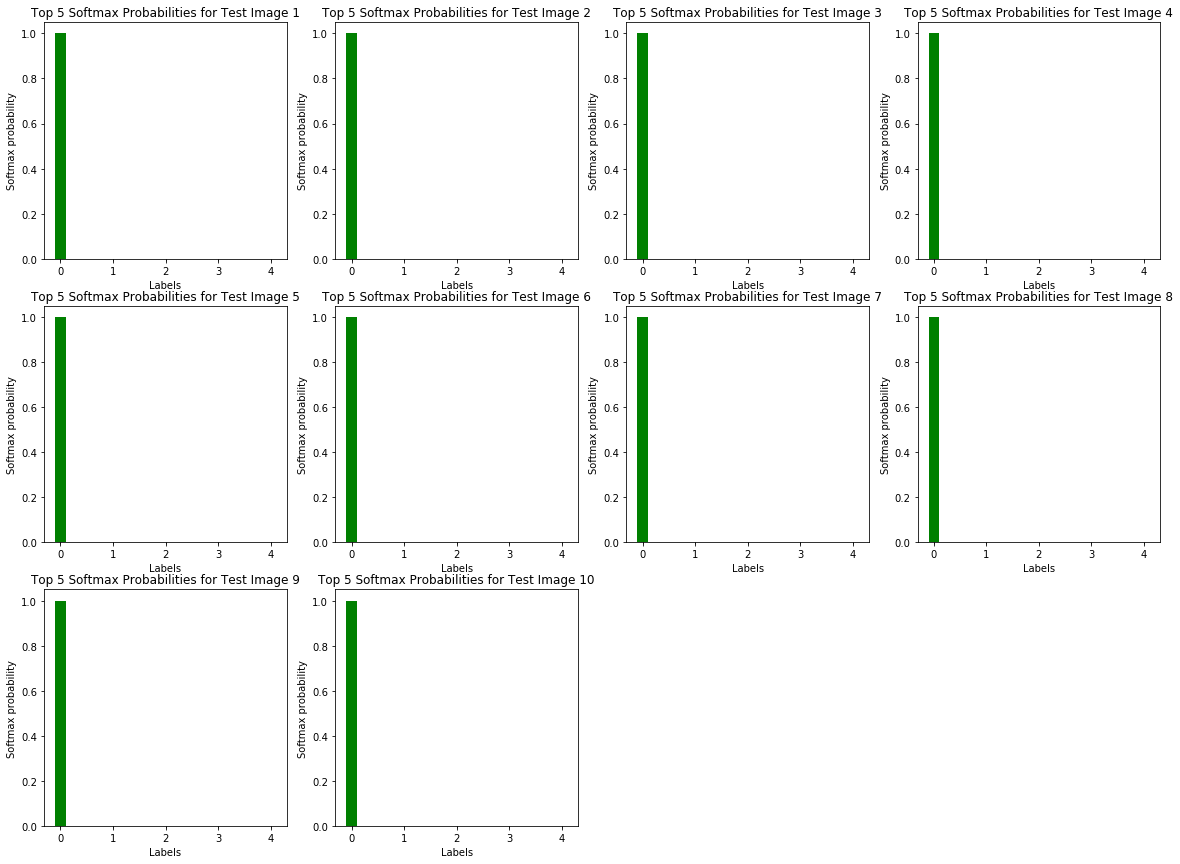

In [26]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
actual_lables = [1,11,12,17,18,22,23,25,34,38]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ## Restore the tuned model parameters
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    ## Get the top five softmax  values for each image
    top_five_softmax=sess.run(tf.nn.top_k(tf.nn.softmax(logits),5),feed_dict={x: gray_images, y: actual_lables})

print("Top Five Softmax Probabilities for Web Images")
print(top_five_softmax)

### Plot the top 5 Softmax Probabilities for all the images 
%matplotlib inline

ind = np.arange(5) 
fig = plt.figure(figsize=(20, 20))  # width, height in inches


for i in range(np.shape(top_five_softmax)[1]):
    values = top_five_softmax[0][i]
    sub = fig.add_subplot(4,4,i+1)
    sub.bar(ind, values, 0.2, color='g')
    sub.set_ylabel('Softmax probability')
    sub.set_xlabel('Labels')
    sub.set_title('Top 5 Softmax Probabilities for Test Image {}'.format(str(i+1)))
    sub.set_xticks(ind, tuple(top_five_softmax[1][i]))

plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.